# Reinforcement Learning with S&P 500 Data

In [83]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv, StocksEnv, ForexEnv, Actions, Positions 

# Reinforcement learning stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3

In [84]:
database = sqlite3.connect("eth_usd_one_day_all_inds.sqlite")
df = pd.read_sql_query("SELECT * FROM prices", database)

df

,id,name,date,high,low,close,high_perc,low_perc,price_chg,massi,mfi,adx,dmp,dmn,rsi,slowd,slowk,target
0,1,ETH-USD,2017-11-09 00:00:00,329.451996,307.056000,320.884003,-2.670122,4.309346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ETH-USD,2017-11-10 00:00:00,324.717987,294.541992,299.252991,-8.509521,1.574253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,ETH-USD,2017-11-11 00:00:00,319.453003,298.191986,314.681000,-1.516457,5.239914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ETH-USD,2017-11-12 00:00:00,319.153015,298.513000,307.907990,-3.652073,3.051233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,ETH-USD,2017-11-13 00:00:00,328.415009,307.024994,316.716003,-3.693847,3.059842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1713,ETH-USD,2022-07-18 00:00:00,1578.717896,1338.806030,1578.717896,0.000000,15.196627,-1.234117,23.354337,81.382805,28.736354,38.753241,19.256374,68.958568,88.238133,93.955666,0.0
1713,1714,ETH-USD,2022-07-19 00:00:00,1607.033081,1501.797485,1542.975220,-4.151581,2.668723,-0.454236,23.707789,82.938091,29.256387,37.864446,17.811679,66.179043,91.681954,92.675718,0.0
1714,1715,ETH-USD,2022-07-20 00:00:00,1612.645752,1500.803223,1520.200684,-6.081110,1.275980,-4.157531,24.043306,72.597124,29.774375,35.267056,16.403174,64.397890,92.602030,91.174708,0.0
1715,1716,ETH-USD,2022-07-21 00:00:00,1595.761963,1472.185425,1576.749512,-1.205800,6.631623,-6.485843,24.364537,73.740701,29.860799,32.233993,16.984104,66.788085,91.002935,89.158378,0.0


In [85]:
# the gym-anytrading expects that the index is a datetime-object

df['Date'] = pd.to_datetime(df['date'])
df.drop(['date'], axis=1, inplace=True)
df.dtypes

id                    int64
name                 object
high                float64
low                 float64
close               float64
high_perc           float64
low_perc            float64
price_chg           float64
massi               float64
mfi                 float64
adx                 float64
dmp                 float64
dmn                 float64
rsi                 float64
slowd               float64
slowk               float64
target              float64
Date         datetime64[ns]
dtype: object

In [86]:
df.columns

Index(['id', 'name', 'high', 'low', 'close', 'high_perc', 'low_perc',
       'price_chg', 'massi', 'mfi', 'adx', 'dmp', 'dmn', 'rsi', 'slowd',
       'slowk', 'target', 'Date'],
      dtype='object')

In [87]:
# Drop all the unnecessary columns and change close to Close because gym-anytrading expects that keyword

df.drop([ "id", "name", "target" ], axis=1, inplace=True)
df.dropna(inplace=True)
df.set_index('Date', inplace=True)
df['Close'] = df['close']
df.drop([ "close" ], axis=1, inplace=True)
df

,high,low,high_perc,low_perc,price_chg,massi,mfi,adx,dmp,dmn,rsi,slowd,slowk,Close
Date,,,,,,,,,,,,,,
2017-12-11,516.968994,439.104004,-0.355830,14.759594,4.163843,27.662598,41.392270,29.453226,31.321265,18.180044,66.967208,50.879146,62.399498,515.135986
2017-12-12,657.317993,504.493988,-0.903697,22.556040,-0.666957,28.204370,57.554122,31.787895,46.515584,13.615391,78.614608,61.198741,75.070985,651.431030
2017-12-13,747.992981,597.797974,-6.435412,14.936537,0.516041,28.799934,71.137688,34.726595,49.424635,10.756839,81.290521,76.794042,92.911645,702.767029
2017-12-14,753.120972,664.989014,-8.235653,4.430333,0.925346,29.173858,79.337011,37.389421,44.316978,9.496872,79.833871,85.743061,89.246554,695.815979
2017-12-15,697.132019,621.060974,-1.853175,9.261043,-1.494342,29.440278,70.558723,38.269918,39.965558,14.234391,77.391422,88.470924,83.254574,684.447998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-17,1378.417480,1329.763306,-2.971812,0.662797,4.090147,22.880627,79.423823,28.361480,29.484041,23.251547,57.940605,78.615488,88.414479,1338.635742
2022-07-18,1578.717896,1338.806030,0.000000,15.196627,-1.234117,23.354337,81.382805,28.736354,38.753241,19.256374,68.958568,88.238133,93.955666,1578.717896
2022-07-19,1607.033081,1501.797485,-4.151581,2.668723,-0.454236,23.707789,82.938091,29.256387,37.864446,17.811679,66.179043,91.681954,92.675718,1542.975220


In [88]:
# Lagged features help the model use previous days as data points, even LSTMs benefit from this even though they
# can check the past datapoints as a default

def make_lags(name, feature, lags):
    return pd.concat(
    {
        f'{name}_lag_{i}': feature.shift(i)
        for i in range(1, lags + 1)
    },
    axis = 1)

df = df.join(make_lags("price", df.Close, lags=5))
df = df.join(make_lags("high", df.high, lags=5))
df = df.join(make_lags("low", df.low, lags=5))
df = df.join(make_lags("pricechg", df.price_chg, lags=5))
df = df.join(make_lags("highperc", df.high_perc, lags=5))
df = df.join(make_lags("lowperc", df.low_perc, lags=5))
df = df.join(make_lags("massi", df.massi, lags=5))
df = df.join(make_lags("mfi", df.mfi, lags=5))
df = df.join(make_lags("adx", df.adx, lags=5))
df = df.join(make_lags("dmp", df.dmp, lags=5))
df = df.join(make_lags("dmn", df.dmn, lags=5))
df = df.join(make_lags("slowk", df.slowk, lags=5))
df = df.join(make_lags("slowd", df.slowd, lags=5))
df = df.join(make_lags("rsi", df.rsi, lags=5))

# Dropping missing values
df.dropna(inplace=True)

X = df

In [89]:
X

,high,low,high_perc,low_perc,price_chg,massi,mfi,adx,dmp,dmn,...,slowd_lag_1,slowd_lag_2,slowd_lag_3,slowd_lag_4,slowd_lag_5,rsi_lag_1,rsi_lag_2,rsi_lag_3,rsi_lag_4,rsi_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-16,718.385010,680.786011,-3.185254,2.215279,-8.094719,29.524443,72.217140,39.294313,40.788055,13.527396,...,88.470924,85.743061,76.794042,61.198741,50.879146,77.391422,79.833871,81.290521,78.614608,66.967208
2017-12-17,735.825012,696.237000,-2.201470,3.297056,1.339749,29.503933,73.704642,40.401598,40.960622,12.805690,...,84.834150,88.470924,85.743061,76.794042,61.198741,78.136668,77.391422,79.833871,81.290521,78.614608
2017-12-18,803.927979,689.231018,-1.168189,13.265546,4.741567,29.386767,78.207149,42.019829,43.587109,10.979326,...,83.211589,84.834150,88.470924,85.743061,76.794042,79.600034,78.136668,77.391422,79.833871,81.290521
2017-12-19,881.943970,785.341980,-6.666599,5.016916,3.689743,29.021989,82.948379,44.019056,47.845047,9.721716,...,85.574317,83.211589,84.834150,88.470924,85.743061,83.366934,79.600034,78.136668,77.391422,79.833871
2017-12-20,845.062012,756.004028,-3.171341,7.701508,-7.194814,28.852511,75.875070,45.003276,42.959623,12.092777,...,88.911777,85.574317,83.211589,84.834150,88.470924,84.679788,83.366934,79.600034,78.136668,77.391422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-17,1378.417480,1329.763306,-2.971812,0.662797,4.090147,22.880627,79.423823,28.361480,29.484041,23.251547,...,62.849730,45.109148,35.520550,41.429607,56.492865,59.075252,51.550333,48.488356,42.125608,34.902782
2022-07-18,1578.717896,1338.806030,0.000000,15.196627,-1.234117,23.354337,81.382805,28.736354,38.753241,19.256374,...,78.615488,62.849730,45.109148,35.520550,41.429607,57.940605,59.075252,51.550333,48.488356,42.125608
2022-07-19,1607.033081,1501.797485,-4.151581,2.668723,-0.454236,23.707789,82.938091,29.256387,37.864446,17.811679,...,88.238133,78.615488,62.849730,45.109148,35.520550,68.958568,57.940605,59.075252,51.550333,48.488356


In [90]:
X.columns

Index(['high', 'low', 'high_perc', 'low_perc', 'price_chg', 'massi', 'mfi',
       'adx', 'dmp', 'dmn', 'rsi', 'slowd', 'slowk', 'Close', 'price_lag_1',
       'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5',
       'high_lag_1', 'high_lag_2', 'high_lag_3', 'high_lag_4', 'high_lag_5',
       'low_lag_1', 'low_lag_2', 'low_lag_3', 'low_lag_4', 'low_lag_5',
       'pricechg_lag_1', 'pricechg_lag_2', 'pricechg_lag_3', 'pricechg_lag_4',
       'pricechg_lag_5', 'highperc_lag_1', 'highperc_lag_2', 'highperc_lag_3',
       'highperc_lag_4', 'highperc_lag_5', 'lowperc_lag_1', 'lowperc_lag_2',
       'lowperc_lag_3', 'lowperc_lag_4', 'lowperc_lag_5', 'massi_lag_1',
       'massi_lag_2', 'massi_lag_3', 'massi_lag_4', 'massi_lag_5', 'mfi_lag_1',
       'mfi_lag_2', 'mfi_lag_3', 'mfi_lag_4', 'mfi_lag_5', 'adx_lag_1',
       'adx_lag_2', 'adx_lag_3', 'adx_lag_4', 'adx_lag_5', 'dmp_lag_1',
       'dmp_lag_2', 'dmp_lag_3', 'dmp_lag_4', 'dmp_lag_5', 'dmn_lag_1',
       'dmn_lag_2', 'dmn_la

In [91]:
# Here we make our custom signal features and prices for gym-anytrading, you can also use the default ones
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, X.columns].to_numpy()[start:end]
    return prices, signal_features

class MyForexEnv(ForexEnv):
    _process_data = my_process_data

# Creating the environment where the agent(=model) trains itself
env = MyForexEnv(df=X, window_size=10, frame_bound=(10, 1000))

In [92]:
env.signal_features

array([[718.38500977, 680.78601074,  -3.18525412, ...,  81.29052095,
         78.61460772,  66.96720796],
       [735.82501221, 696.23699951,  -2.20147049, ...,  79.83387145,
         81.29052095,  78.61460772],
       [803.92797852, 689.23101807,  -1.16818941, ...,  77.39142188,
         79.83387145,  81.29052095],
       ...,
       [355.56286621, 328.81677246,  -5.32009539, ...,  38.29563858,
         47.50475019,  46.93008942],
       [359.16448975, 332.16500854,  -2.29400288, ...,  42.40399737,
         38.29563858,  47.50475019],
       [377.39358521, 351.11175537,  -2.524216  , ...,  42.28862258,
         42.40399737,  38.29563858]])

info {'total_reward': -4278850.09765625, 'total_profit': 0.7093021057870453, 'position': 1}


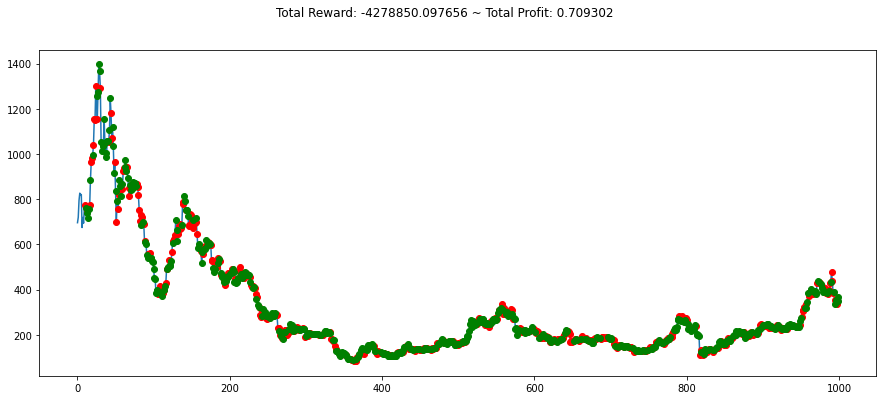

In [93]:
# Testing random actions in the environment
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [94]:
from stable_baselines3.common.monitor import Monitor

# Saving directory for the training/testing results so we can plot them later
test_env_dir = './logs/test_env/test'
log_dir = './logs/main_env/real'

# Wrapping environment in a vector and setting up monitor for result saving
env = DummyVecEnv([lambda: Monitor(MyForexEnv(df=X, window_size=10, frame_bound=(10, 800)), log_dir)])

In [ ]:
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from sb3_contrib.ppo_recurrent.ppo_recurrent import RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import PPO
from stable_baselines3 import DQN

test_env = DummyVecEnv([lambda: Monitor(MyForexEnv(df=X, window_size=10, frame_bound=(800, 1600)), test_env_dir)])

# EvalCallback = 
# Evaluate periodically the performance of an agent, using a separate test environment.
# In market data it's important the eval_freq is the same as how many datapoints you got
eval_callback = EvalCallback(test_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=800, n_eval_episodes=10,
                             deterministic=True, render=False)

# total_timesteps is the number of steps in total the agent will do for any environment. 
# The total_timesteps can be across several episodes, meaning that this value is not bound to some maximum.
model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003, seed=42)
model.learn(total_timesteps=100000, callback=eval_callback)

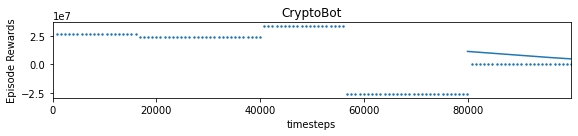

In [96]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

test_env_dir = './logs/test_env/'
# Helper from the library
results_plotter.plot_results([test_env_dir], 1e5, results_plotter.X_TIMESTEPS, "CryptoBot")

In [97]:
# Plotting
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

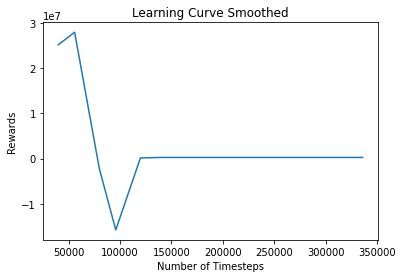

In [98]:
# Here we can see if our model has converged, it the line is flat for a long time 
# - the model has most likely converged i.e. it's not learning anymore
plot_results('./logs/test_env/')

In [99]:
# Loading the best model
model = PPO.load('./logs/best_model.zip')

info {'total_reward': -7899376.8310546875, 'total_profit': 0.3361938442446646, 'position': 1}
info {'total_reward': -52795115.20385742, 'total_profit': 0.3943808998267758, 'position': 1}
info {'total_reward': -14491328.887939453, 'total_profit': 0.12124599591635758, 'position': 1}
info {'total_reward': -19083452.911376953, 'total_profit': 0.2883997218827514, 'position': 1}
info {'total_reward': -73398804.77905273, 'total_profit': 0.14566896937419013, 'position': 1}
info {'total_reward': -12645664.672851562, 'total_profit': 0.23056553529980647, 'position': 1}
info {'total_reward': 46303797.302246094, 'total_profit': 0.8275159397044276, 'position': 1}
info {'total_reward': 9774831.39038086, 'total_profit': 0.21030607700931184, 'position': 1}
info {'total_reward': -15329468.078613281, 'total_profit': 0.13394439012093878, 'position': 1}
info {'total_reward': -43262047.271728516, 'total_profit': 0.29948932508030834, 'position': 1}

Average profit in ten runs: 0.29877106984595325


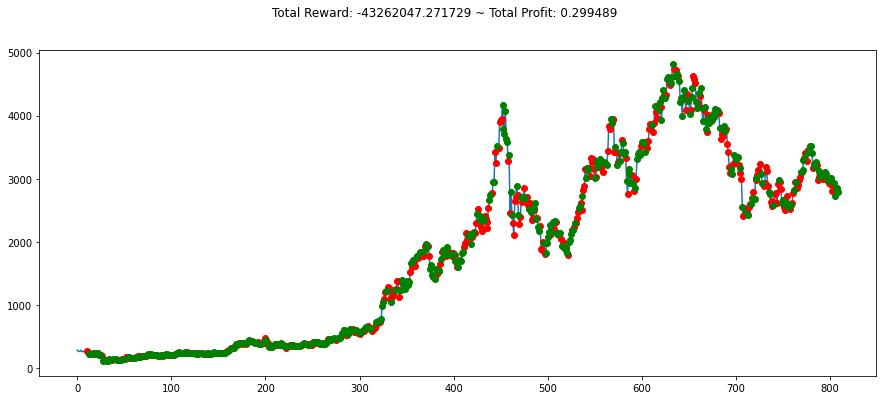

In [100]:
# Testing the model for ten runs
avg_profit = []
for i in range(10):
    test_env = MyForexEnv(df=X, window_size=10, frame_bound=(800, 1600))
    obs = test_env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = test_env.step(action)
        if done:
            avg_profit.append(info["total_profit"])
            print("info", info)
            break

print("\nAverage profit in ten runs:", np.mean(avg_profit))
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()

As we can see the agent has some reproducibility issues which is not uncommon in reinforcement learning agents. It's because rl agents are stochastic, meaning random in a way, which is not great for trading of course.